# NekRS-ML GNN Scaling on Frontier

In [33]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [34]:
class NekRSML_GNN:
    def __init__(self,path,gpu_list):
        self.base_path = path
        self.gpu_list = gpu_list
        self.n_gpu = len(gpu_list)
        self.train_fom = {
            'train_tot': np.zeros((self.n_gpu,)),
            'train_epoch': np.zeros((self.n_gpu,4)),
            'throughput_epoch': np.zeros((self.n_gpu,4)),
            'train_batch': np.zeros((self.n_gpu,4)),
            'throughput_batch': np.zeros((self.n_gpu,4)),
            'throughput_epoch_par': np.zeros((self.n_gpu,)),
            'throughput_batch_par': np.zeros((self.n_gpu,)),
            'forward_pass': np.zeros((self.n_gpu,4)),
            'loss': np.zeros((self.n_gpu,4)),
            'backward_pass': np.zeros((self.n_gpu,4)),
            'optimizer_step': np.zeros((self.n_gpu,4)),
            'data_offload': np.zeros((self.n_gpu,4)),
            'buffer_init': np.zeros((self.n_gpu,4)),
            'collectives': np.zeros((self.n_gpu,4))
        }
        self.counts = {
            'train_tot': np.zeros((self.n_gpu,)),
            'train_epoch': np.zeros((self.n_gpu,)),
            'throughput_epoch': np.zeros((self.n_gpu,)),
            'train_batch': np.zeros((self.n_gpu,)),
            'throughput_batch': np.zeros((self.n_gpu,)),
            'throughput_epoch_par': np.zeros((self.n_gpu,)),
            'throughput_batch_par': np.zeros((self.n_gpu,)),
            'forward_pass': np.zeros((self.n_gpu,)),
            'loss': np.zeros((self.n_gpu,)),
            'backward_pass': np.zeros((self.n_gpu,)),
            'optimizer_step': np.zeros((self.n_gpu,)),
            'data_offload': np.zeros((self.n_gpu,)),
            'buffer_init': np.zeros((self.n_gpu,)),
            'collectives': np.zeros((self.n_gpu,))
        }
        self.scaling_ideal = np.zeros((self.n_gpu,))
        self.scaling_efficiency = np.zeros((self.n_gpu,))
        
    def get_value(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        return float(string.split(":")[1].strip())
    
    def get_values(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        vals = string.split(":")[1].split(",")
        arr = np.zeros((4,))
        for i in range(4):
            arr[i] = float(vals[i].split('=')[-1].strip())
        return arr
    
    def parse_files(self):
        for i in range(self.n_gpu):
            path = self.base_path+f"/{self.gpu_list[i]}/gnn_scale.*"
            #path = self.base_path+f"/{self.gpu_list[i]}/gnn_s*"
            # Loop over runs found
            run_files = glob.glob(path)
            for run_file in run_files:
                print('Reading file: ', run_file)
                with open(run_file,'r') as fh:
                    for l in fh:
                        if "Total training time" in l and "::" not in l:
                            self.train_fom['train_tot'][i] += self.get_value(l)
                            self.counts['train_tot'][i] += 1
                            
                        if "Training epoch" in l:
                            self.train_fom['train_epoch'][i] += self.get_values(l)
                            self.counts['train_epoch'][i] += 1
                        if "Training throughput" in l:
                            self.train_fom['throughput_epoch'][i] += self.get_values(l)
                            self.counts['throughput_epoch'][i] += 1
                        if "Average parallel training throughout" in l:
                            self.train_fom['throughput_epoch_par'][i] += self.get_value(l)
                            self.counts['throughput_epoch_par'][i] += 1
                            
                        if "Training batch" in l and "throughput" not in l:
                            self.train_fom['train_batch'][i] += self.get_values(l)
                            self.counts['train_batch'][i] += 1
                        if "Training batch throughput" in l:
                            self.train_fom['throughput_batch'][i] += self.get_values(l)
                            self.counts['throughput_batch'][i] += 1
                        if "Average parallel training batch throughout" in l:
                            self.train_fom['throughput_batch_par'][i] += self.get_value(l)
                            self.counts['throughput_batch_par'][i] += 1
                            
                        if "forwardPass" in l:
                            self.train_fom['forward_pass'][i] += self.get_values(l)
                            self.counts['forward_pass'][i] += 1
                        if "loss [" in l:
                            self.train_fom['loss'][i] += self.get_values(l)
                            self.counts['loss'][i] += 1
                        if "backwardPass" in l:
                            self.train_fom['backward_pass'][i] += self.get_values(l)
                            self.counts['backward_pass'][i] += 1
                        if "optimizerStep" in l:
                            self.train_fom['optimizer_step'][i] += self.get_values(l)
                            self.counts['optimizer_step'][i] += 1
                        if "dataTransfer" in l:
                            self.train_fom['data_offload'][i] += self.get_values(l)
                            self.counts['data_offload'][i] += 1
                        if "bufferInit" in l:
                            self.train_fom['buffer_init'][i] += self.get_values(l)
                            self.counts['buffer_init'][i] += 1
                        if "collectives" in l:
                            self.train_fom['collectives'][i] += self.get_values(l)
                            self.counts['collectives'][i] += 1

        # Divide by the counts for each gpu number to get the average over runs
        for key in self.train_fom.keys():
            val = self.train_fom[key]
            if len(val.shape)==1:
                #self.train_fom[key] = np.divide(val, self.counts[key], where=self.counts[key]>0)
                np.divide(val, self.counts[key], out=self.train_fom[key], where=self.counts[key]>0)
            else:
                for j in range(val.shape[1]):
                    #self.train_fom[key][:,j] = np.divide(val[:,j], self.counts[key], where=self.counts[key]>0)
                    np.divide(val[:,j], self.counts[key], out=self.train_fom[key][:,j], where=self.counts[key]>0)
                    
        # Compute the scaling efficiency
        single_node = self.train_fom['throughput_epoch_par'][3]
        self.scaling_ideal = np.array([self.gpu_list[3+i]/self.gpu_list[3]*single_node for i in range(len(self.gpu_list[3:]))])
        self.scaling_efficiency = 100*self.train_fom['throughput_epoch_par'][3:]/self.scaling_ideal

## Load All Data

In [173]:
top_dir = "/Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/"

In [174]:
#### Frontier, 500k, large
# NekRS-ML Model, no halo exchange
case_dir = "frontier/500k/large/none"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_l_no = NekRSML_GNN(dir_path,gpu_list)
frontier_5_l_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "frontier/500k/large/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_l_a2a = NekRSML_GNN(dir_path,gpu_list)
frontier_5_l_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "frontier/500k/large/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_l_a2ao = NekRSML_GNN(dir_path,gpu_list)
frontier_5_l_a2ao.parse_files()




Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/4/gnn_scale.o2180992
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/4/gnn_scale.o2200432
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/8/gnn_scale.o2180992
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/8/gnn_scale.o2200433
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/16/gnn_scale.o2200437
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/32/gnn_scale.o2200706
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/64/gnn_scale.o2200451
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/128/gnn_scale.o2200453
Reading file:  /Users/rbali

In [175]:
#### Frontier, 500k, small
# NekRS-ML Model, no halo exchange
case_dir = "frontier/500k/small/none"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_s_no = NekRSML_GNN(dir_path,gpu_list)
frontier_5_s_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "frontier/500k/small/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_s_a2a = NekRSML_GNN(dir_path,gpu_list)
frontier_5_s_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "frontier/500k/small/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_5_s_a2ao = NekRSML_GNN(dir_path,gpu_list)
frontier_5_s_a2ao.parse_files()

Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/4/gnn_scale.o2201653
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/8/gnn_scale.o2201654
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/16/gnn_scale.o2201655
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/32/gnn_scale.o2201656
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/64/gnn_scale.o2201657
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/128/gnn_scale.o2201658
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/256/gnn_scale.o2201659
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/none/512/gnn_scale.o2201660
Reading file:  /Users/r

<ipython-input-34-fd16f23f7208>:125: RuntimeWarning: invalid value encountered in true_divide
  self.scaling_efficiency = 100*self.train_fom['throughput_epoch_par'][3:]/self.scaling_ideal


Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/4/gnn_scale.o2201662
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/8/gnn_scale.o2201663
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/16/gnn_scale.o2201664
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/32/gnn_scale.o2201665
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/64/gnn_scale.o2201666
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/128/gnn_scale.o2201667
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/all2all_opt/256/gnn_scale.o2201668
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/small/al

In [176]:
#### Frontier, 250k, large
# NekRS-ML Model, no halo exchange
case_dir = "frontier/250k/large/none"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_l_no = NekRSML_GNN(dir_path,gpu_list)
frontier_2_l_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "frontier/250k/large/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_l_a2a = NekRSML_GNN(dir_path,gpu_list)
frontier_2_l_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "frontier/250k/large/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_l_a2ao = NekRSML_GNN(dir_path,gpu_list)
frontier_2_l_a2ao.parse_files()




Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/4/gnn_scale.o2200586
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/8/gnn_scale.o2200588
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/16/gnn_scale.o2200589
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/32/gnn_scale.o2200626
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/64/gnn_scale.o2200627
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/128/gnn_scale.o2200628
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/256/gnn_scale.o2200629
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/none/512/gnn_scale.o2200630
Reading file:  /Users/r

<ipython-input-34-fd16f23f7208>:125: RuntimeWarning: invalid value encountered in true_divide
  self.scaling_efficiency = 100*self.train_fom['throughput_epoch_par'][3:]/self.scaling_ideal


Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/4/gnn_scale.o2201644
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/8/gnn_scale.o2201645
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/16/gnn_scale.o2201646
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/32/gnn_scale.o2201647
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/64/gnn_scale.o2201648
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/128/gnn_scale.o2201649
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/all2all_opt/256/gnn_scale.o2201650
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/large/al

In [177]:
#### Frontier, 250k, small
# NekRS-ML Model, no halo exchange
case_dir = "frontier/250k/small/none"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_s_no = NekRSML_GNN(dir_path,gpu_list)
frontier_2_s_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "frontier/250k/small/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_s_a2a = NekRSML_GNN(dir_path,gpu_list)
frontier_2_s_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "frontier/250k/small/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_2_s_a2ao = NekRSML_GNN(dir_path,gpu_list)
frontier_2_s_a2ao.parse_files()




Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/4/gnn_scale.o2200755
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/8/gnn_scale.o2200756
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/16/gnn_scale.o2200757
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/32/gnn_scale.o2200758
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/64/gnn_scale.o2200759
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/128/gnn_scale.o2200760
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/256/gnn_scale.o2200761
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/250k/small/none/512/gnn_scale.o2200762
Reading file:  /Users/r

## Scale-Out of NekRS-ML GNN

In [169]:
frontier_5_s_no.scaling_efficiency

array([100.        ,  99.34860905,  98.06567461,  97.87602664,
        97.09669975,  91.42797125,  91.16087815,  91.0143645 ,
        92.47969365])

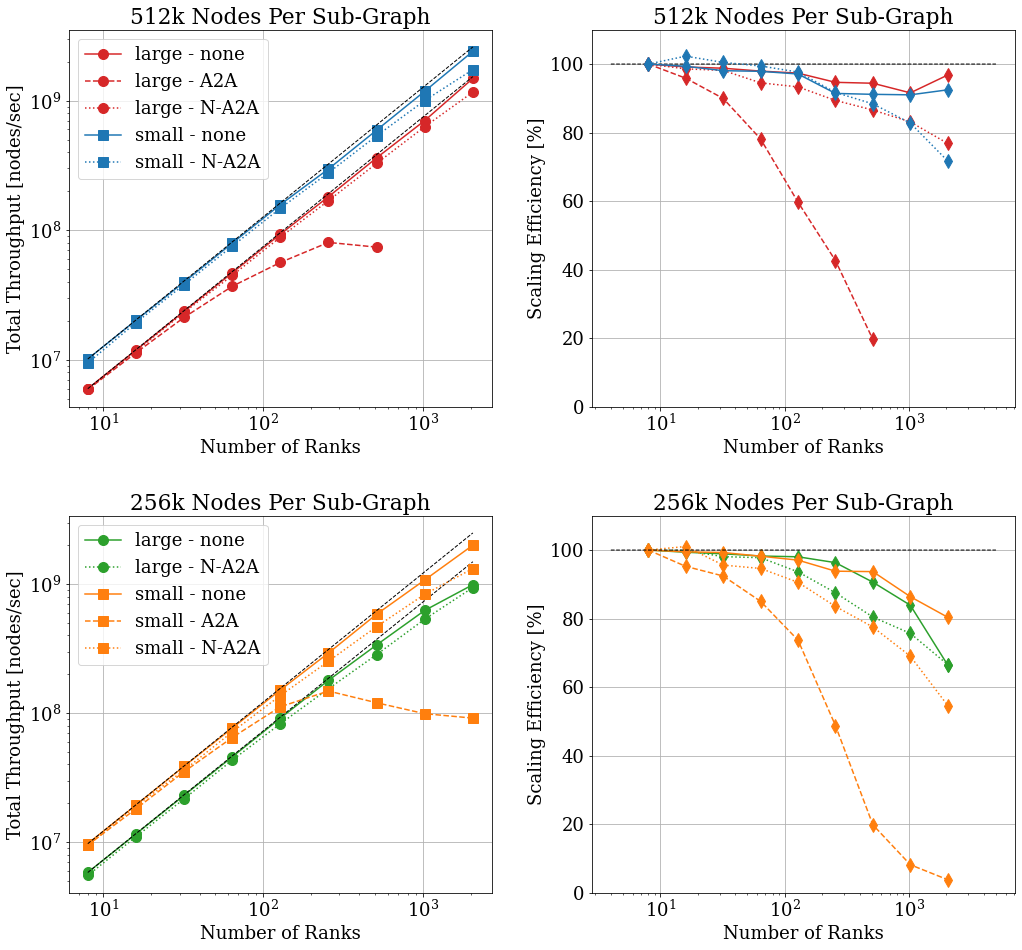

In [178]:
# Average parallel training throughput, based on epoch time

frontier_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_rank_list = [i*2 for i in frontier_gpu_list]
frontier_no_single_node = frontier_5_l_no.train_fom['throughput_epoch_par'][3]
frontier_no_ideal = [frontier_rank_list[i]/frontier_rank_list[0]*frontier_no_single_node for i in range(len(frontier_rank_list))]


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 14))
axs[0,0].plot(frontier_rank_list, frontier_5_l_no.train_fom['throughput_epoch_par'][3:],label = "large - none",marker="o",ls="-",markersize=10,color='tab:red')
axs[0,0].plot(frontier_rank_list[:8], frontier_5_l_a2a.train_fom['throughput_epoch_par'][3:11],label = "large - A2A",marker="o",ls="--",markersize=10,color='tab:red')
axs[0,0].plot(frontier_rank_list, frontier_5_l_a2ao.train_fom['throughput_epoch_par'][3:],label = "large - N-A2A",marker="o",ls=":",markersize=10,color='tab:red')
axs[0,0].plot(frontier_rank_list, frontier_5_l_no.scaling_ideal,c="k",ls="--",linewidth=1)

axs[0,0].plot(frontier_rank_list, frontier_5_s_no.train_fom['throughput_epoch_par'][3:],label = "small - none",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0,0].plot(frontier_rank_list, frontier_5_s_a2ao.train_fom['throughput_epoch_par'][3:],label = "small - N-A2A",marker="s",ls=":",markersize=10,color='tab:blue')
axs[0,0].plot(frontier_rank_list, frontier_5_s_no.scaling_ideal,c="k",ls="--",linewidth=1)

axs[1,0].plot(frontier_rank_list, frontier_2_l_no.train_fom['throughput_epoch_par'][3:],label = "large - none",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,0].plot(frontier_rank_list, frontier_2_l_a2ao.train_fom['throughput_epoch_par'][3:],label = "large - N-A2A",marker="o",ls=":",markersize=10,color='tab:green')
axs[1,0].plot(frontier_rank_list, frontier_2_l_no.scaling_ideal,c="k",ls="--",linewidth=1)

axs[1,0].plot(frontier_rank_list, frontier_2_s_no.train_fom['throughput_epoch_par'][3:],label = "small - none",marker="s",ls="-",markersize=10,color='tab:orange')
axs[1,0].plot(frontier_rank_list, frontier_2_s_a2a.train_fom['throughput_epoch_par'][3:],label = "small - A2A",marker="s",ls="--",markersize=10,color='tab:orange')
axs[1,0].plot(frontier_rank_list, frontier_2_s_a2ao.train_fom['throughput_epoch_par'][3:],label = "small - N-A2A",marker="s",ls=":",markersize=10,color='tab:orange')
axs[1,0].plot(frontier_rank_list, frontier_2_s_no.scaling_ideal,c="k",ls="--",linewidth=1)

axs[0,1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)



axs[0,1].plot(frontier_rank_list, frontier_5_l_no.scaling_efficiency,label = "Frontier no",marker="d",ls="-",markersize=10,color='tab:red')
axs[0,1].plot(frontier_rank_list[:8], frontier_5_l_a2a.scaling_efficiency[:8],label = "Frontier a2a",marker="d",ls="--",markersize=10,color='tab:red')
axs[0,1].plot(frontier_rank_list, frontier_5_l_a2ao.scaling_efficiency,label = "Frontier a2a opt.",marker="d",ls=":",markersize=10,color='tab:red')

axs[0,1].plot(frontier_rank_list, frontier_5_s_no.scaling_efficiency,label = "Frontier no",marker="d",ls="-",markersize=10,color='tab:blue')
axs[0,1].plot(frontier_rank_list, frontier_5_s_a2ao.scaling_efficiency,label = "Frontier a2a opt.",marker="d",ls=":",markersize=10,color='tab:blue')

axs[1,1].plot(frontier_rank_list, frontier_2_l_no.scaling_efficiency,label = "Frontier no",marker="d",ls="-",markersize=10,color='tab:green')
axs[1,1].plot(frontier_rank_list, frontier_2_l_a2ao.scaling_efficiency,label = "Frontier a2a opt.",marker="d",ls=":",markersize=10,color='tab:green')

axs[1,1].plot(frontier_rank_list, frontier_2_s_no.scaling_efficiency,label = "Frontier no",marker="d",ls="-",markersize=10,color='tab:orange')
axs[1,1].plot(frontier_rank_list, frontier_2_s_a2a.scaling_efficiency,label = "Frontier a2a",marker="d",ls="--",markersize=10,color='tab:orange')
axs[1,1].plot(frontier_rank_list, frontier_2_s_a2ao.scaling_efficiency,label = "Frontier a2a opt.",marker="d",ls=":",markersize=10,color='tab:orange')

axs[1,1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    for j in range(2):
        axs[i,j].set_xscale("log")
        axs[i,j].grid()
        axs[i,j].set_xlabel('Number of Ranks')

axs[0,0].set_yscale("log")
axs[1,0].set_yscale("log")
axs[0,1].set_ylim(0,110)
axs[1,1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0,0].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[0,0].set_ylabel('Total Throughput [nodes/sec]')
axs[1,0].set_ylabel('Total Throughput [nodes/sec]')
axs[0,0].set_title('512k Nodes Per Sub-Graph')
axs[1,0].set_title('256k Nodes Per Sub-Graph')
axs[0,1].set_ylabel('Scaling Efficiency [%]')
axs[1,1].set_ylabel('Scaling Efficiency [%]')
axs[0,1].set_title('512k Nodes Per Sub-Graph')
axs[1,1].set_title('256k Nodes Per Sub-Graph')
fig.tight_layout(pad=2.0)
fig.savefig("frontier_NekRS-ML_scaling.pdf", format="pdf")

In [185]:
1*frontier_2_l_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_2_l_no.train_fom['throughput_epoch_par'][3:]

array([0.94789614, 0.95259553, 0.93994655, 0.943149  , 0.90535012,
       0.8613678 , 0.84138617, 0.85508395, 0.94980531])

In [183]:
1*frontier_5_s_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_5_s_no.train_fom['throughput_epoch_par'][3:]

array([0.93255791, 0.96034065, 0.95547835, 0.94751938, 0.93788184,
       0.93554052, 0.90398914, 0.84822755, 0.72281321])

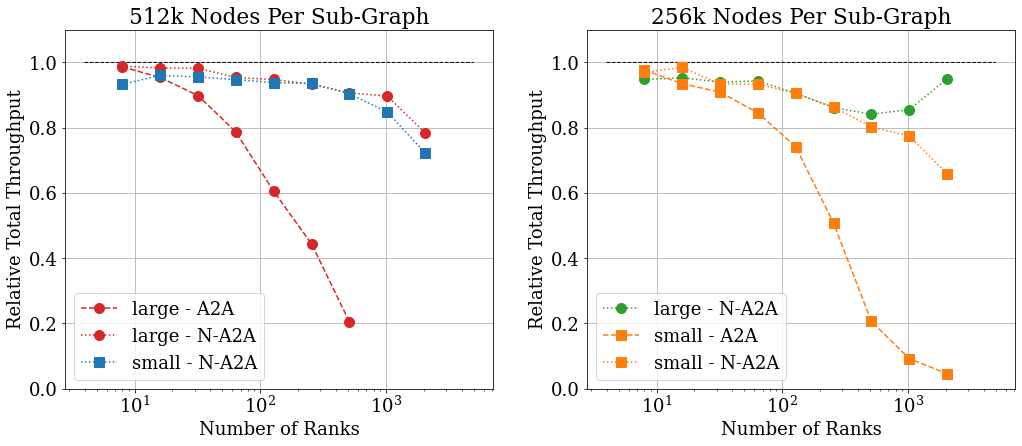

In [179]:
# Throughput relative to NO HALO, based on epoch time, for 500k

frontier_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_rank_list = [i*2 for i in frontier_gpu_list]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)
axs[1].plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)

axs[0].plot(frontier_rank_list[:8], 1*frontier_5_l_a2a.train_fom['throughput_epoch_par'][3:11]/frontier_5_l_no.train_fom['throughput_epoch_par'][3:11],label = "large - A2A",marker="o",ls="--",markersize=10, color='tab:red')
axs[0].plot(frontier_rank_list, 1*frontier_5_l_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_5_l_no.train_fom['throughput_epoch_par'][3:],label = "large - N-A2A",marker="o",ls=":",markersize=10, color='tab:red')

#axs[0].plot(frontier_rank_list[:5], 100*frontier_5_s_a2a.train_fom['throughput_epoch_par'][3:8]/frontier_5_l_no.train_fom['throughput_epoch_par'][3:8],label = "a2a",marker="o",ls="--",markersize=10, color='tab:red')
axs[0].plot(frontier_rank_list, 1*frontier_5_s_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_5_s_no.train_fom['throughput_epoch_par'][3:],label = "small - N-A2A",marker="s",ls=":",markersize=10, color='tab:blue')

#axs[1].plot(frontier_rank_list, 100*frontier_2_l_a2a.train_fom['throughput_epoch_par'][3:8]/frontier_5_l_no.train_fom['throughput_epoch_par'][3:8],label = "a2a",marker="o",ls="--",markersize=10, color='tab:red')
axs[1].plot(frontier_rank_list, 1*frontier_2_l_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_2_l_no.train_fom['throughput_epoch_par'][3:],label = "large - N-A2A",marker="o",ls=":",markersize=10, color='tab:green')

axs[1].plot(frontier_rank_list, 1*frontier_2_s_a2a.train_fom['throughput_epoch_par'][3:]/frontier_2_s_no.train_fom['throughput_epoch_par'][3:],label = "small - A2A",marker="s",ls="--",markersize=10, color='tab:orange')
axs[1].plot(frontier_rank_list, 1*frontier_2_s_a2ao.train_fom['throughput_epoch_par'][3:]/frontier_2_s_no.train_fom['throughput_epoch_par'][3:],label = "small - N-A2A",marker="s",ls=":",markersize=10, color='tab:orange')


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of Ranks')

axs[0].set_ylim(0,1.10)
axs[1].set_ylim(0,1.10)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
axs[0].set_ylabel('Relative Total Throughput')
axs[1].set_ylabel('Relative Total Throughput')
axs[0].set_title('512k Nodes Per Sub-Graph')
axs[1].set_title('256k Nodes Per Sub-Graph')
fig.tight_layout(pad=2.0)
fig.savefig("frontier_NekRS-ML_relative_scaling.pdf", format="pdf")

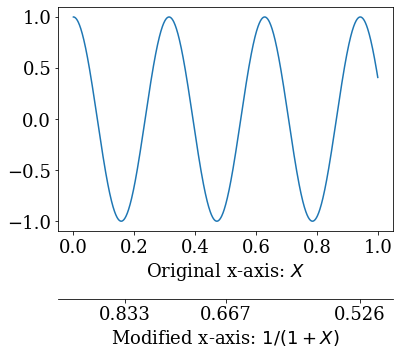

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.1)

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.3))

# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)

# as @ali14 pointed out, for python3, use this
# for sp in ax2.spines.values():
# and for python2, use this
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)

ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()

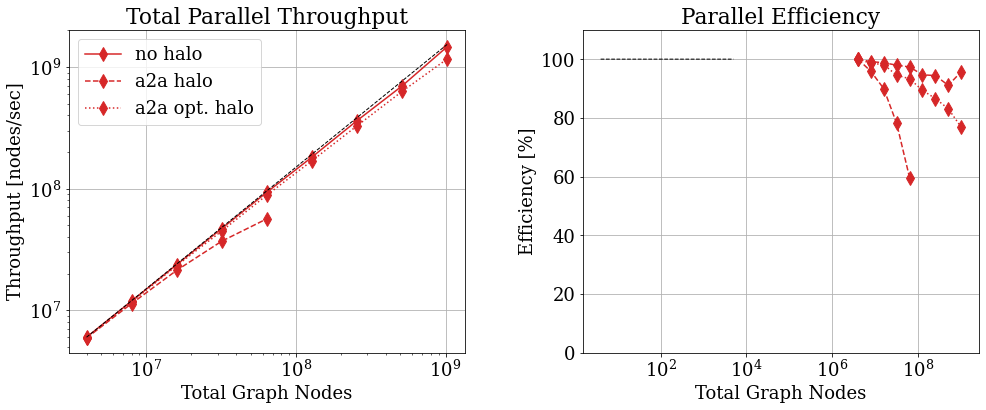

In [88]:
# Average parallel training throughput, based on epoch time

frontier_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
frontier_rank_list = [i*2 for i in frontier_gpu_list]
frontier_no_single_node = frontier_5_l_no.train_fom['throughput_epoch_par'][3]
frontier_no_ideal = [frontier_gpu_list[i]/frontier_gpu_list[0]*frontier_no_single_node for i in range(len(frontier_gpu_list))]

graph_nodes = [i*500_000 for i in frontier_rank_list]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(graph_nodes, frontier_5_l_no.train_fom['throughput_epoch_par'][3:],label = "no halo",marker="d",ls="-",markersize=10,color='tab:red')
axs[0].plot(graph_nodes[:5], frontier_5_l_a2a.train_fom['throughput_epoch_par'][3:8],label = "a2a halo",marker="d",ls="--",markersize=10,color='tab:red')
axs[0].plot(graph_nodes, frontier_5_l_a2ao.train_fom['throughput_epoch_par'][3:],label = "a2a opt. halo",marker="d",ls=":",markersize=10,color='tab:red')
axs[0].plot(graph_nodes, frontier_no_ideal,c="k",ls="--",linewidth=1)

axs[1].plot(graph_nodes, frontier_5_l_no.scaling_efficiency,label = "Frontier no",marker="d",ls="--",markersize=10,color='tab:red')
axs[1].plot(graph_nodes[:5], frontier_5_l_a2a.scaling_efficiency[:5],label = "Frontier a2a",marker="d",ls="--",markersize=10,color='tab:red')
axs[1].plot(graph_nodes, frontier_5_l_a2ao.scaling_efficiency,label = "Frontier a2a opt.",marker="d",ls=":",markersize=10,color='tab:red')

axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Total Graph Nodes')

axs[0].set_yscale("log")
axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')

#axs2_0 = axs[0].twiny()
#axs2_0.xaxis.set_ticks_position("bottom")
#axs2_0.xaxis.set_label_position("bottom")
#axs2_0.spines["bottom"].set_position(("axes", -0.3))
#axs2_0.set_frame_on(True)
#axs2_0.patch.set_visible(False)
#for sp in axs2_0.spines.values():
#    sp.set_visible(False)
#axs2_0.spines["bottom"].set_visible(True)
##axs2_0.set_xticks([0., 0.5, 1.])
##axs2_0.set_xticklabels([500, 1000, 2000])
##axs2_0.set_xlim(axs[0].get_xlim())
#axs2_0.set_xlabel("Total Graph Nodes")
#axs2_0.set_xscale("log")
#axs2_0.set_xticks([graph_nodes[i] for i in range(len(graph_nodes)) if i%2==0])
#axs2_0.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#axs2_0.set_xlim(1e6, 1e9)

fig.tight_layout(pad=3.0)

In [92]:
axs[0].get_xticks()
axs[0].get_xticklabels()

array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11])

In [160]:
class GNNStats:
    def __init__(self,path,gpu_list):
        self.base_path = path
        self.gpu_list = gpu_list
        self.n_gpu = len(gpu_list)
        self.stats = {
            'local_nodes': np.zeros((self.n_gpu,4)),
            'halo_nodes': np.zeros((self.n_gpu,4)),
            'neighbors': np.zeros((self.n_gpu,4)),
        }
        
    def get_graph_nodes(self,string):
        return float(string.split(",")[1].split(":")[-1].strip())
    
    def get_halo_nodes(self,string):
        return float(string.split(",")[2].split(":")[-1].strip())
    
    def get_neighbors(self,string):
        return int(string.split("Found")[-1].split("neighboring")[0].strip())
    
    def parse_files(self):
        for i in range(self.n_gpu):
            path = self.base_path+f"/{self.gpu_list[i]}/gnn_scale.*"
            #path = self.base_path+f"/{self.gpu_list[i]}/gnn_s*"
            # Loop over runs found
            run_files = glob.glob(path)
            dict_lists = {"local_nodes": [],
                          'halo_nodes': [],
                          'neighbors': []}
            local_nodes_list = []
            halo_nodes_list = []
            neighbors_list = []
            for run_file in run_files:
                print('Reading file: ', run_file)
                with open(run_file,'r') as fh:
                    for l in fh:
                        if "number of local nodes" in l:
                            dict_lists["local_nodes"].append(self.get_graph_nodes(l))
                        if "number of halo nodes" in l:
                            dict_lists["halo_nodes"].append(self.get_halo_nodes(l))
                        if "neighboring processes" in l:
                            dict_lists["neighbors"].append(self.get_neighbors(l))
            
            for key in self.stats.keys():
                self.stats[key][i,0] = min(dict_lists[key])
                self.stats[key][i,1] = max(dict_lists[key])
                self.stats[key][i,2] = sum(dict_lists[key])/len(dict_lists[key])
                self.stats[key][i,3] = sum(dict_lists[key])

In [161]:
case_dir = "frontier/500k/large/none"
dir_path = top_dir + case_dir
gpu_list = [4, 32, 256, 1024]
stats = GNNStats(dir_path,gpu_list)
stats.parse_files()
print(stats.stats["local_nodes"])
print(stats.stats["halo_nodes"])
print(stats.stats["neighbors"])

Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/4/gnn_scale.o2180992
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/4/gnn_scale.o2200432
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/32/gnn_scale.o2200706
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/256/gnn_scale.o2200454
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/1024/gnn_scale.o2200457
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/frontier/500k/large/none/1024/gnn_scale.o2200749
[[5.18400000e+05 5.18400000e+05 5.18400000e+05 8.29440000e+06]
 [5.39601000e+05 5.39601000e+05 5.39601000e+05 3.45344640e+07]
 [5.28080000e+05 5.44323000e+05 5.33764000e+05 2.73287168e+08]
 [5.39601000e+05 5.39601000e+05 5.39601000e+05 2.21020570e+09]]
[[1.28000000